In [ ]:
import os
import pandas as pd
import numpy as np
from time import time
from datetime import datetime, timedelta
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from keras.layers import Input, Embedding, concatenate, Flatten, Dense, Dropout, merge
from keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint



In [ ]:
np.random.seed(1337)

In [ ]:
#column header for the dataset
data_cols = ['user id','movie id','rating','timestamp']
item_cols = ['movie id','movie title','release data',
             'video release date','IMDb URL','unknown','Action',
             'Adventure','Animation','Childrens','Comedy','Crime',
             'Documentary','Drama','Fantasy','Film-Noir','Horror',
             'Musical','Mystery','Romance ','Sci-Fi','Thriller',
             'War' ,'Western']
user_cols = ['user id','age','gender','occupation','zip code']

In [ ]:
#importing the data files onto dataframes - 100k
#https://www.kaggle.com/prajitdatta/movielens-100k-dataset

#####데이터 파일 "구현 모음" 으로 옮김 !!!!!

users = pd.read_csv('/content/drive/Shareddrives/DSL_2021_2_추천시스템/추천시스템 공부/구현 모음/wide_and_deep/movielens 100k/u.user',sep='|',names = user_cols, encoding='latin-1')
item = pd.read_csv('/content/drive/Shareddrives/DSL_2021_2_추천시스템/추천시스템 공부/구현 모음/wide_and_deep/movielens 100k/u.item',sep='|',names=item_cols, encoding='latin-1')
data = pd.read_csv('/content/drive/Shareddrives/DSL_2021_2_추천시스템/추천시스템 공부/구현 모음/wide_and_deep/movielens 100k/u.data', sep='\t',names=data_cols, encoding='latin-1')

In [ ]:
#importing the data files onto dataframes - 1m
# https://www.kaggle.com/vatsal73/movielens-1m

# users = pd.read_csv('data/ml-1m/users.dat', sep='::', header=None, engine='python', names=user_cols)
# item = pd.read_csv('data/ml-1m/movies.dat', sep='::', header=None, engine='python', names=item_cols)
# data = pd.read_csv('data/ml-1m/ratings.dat', sep='::', header=None, engine='python', names=data_cols)

In [ ]:
users.head()

,user id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [ ]:
item.head()

,movie id,movie title,release data,video release date,IMDb URL,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [ ]:
data.head()

,user id,movie id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
print(users.shape)
print(item.shape)
print(data.shape)

(943, 5)
(1682, 24)
(100000, 4)


In [ ]:
df = pd.merge(pd.merge(item,data),users)

In [ ]:
df.isnull().sum()

movie id                   0
movie title                0
release data               9
video release date    100000
IMDb URL                  13
unknown                    0
Action                     0
Adventure                  0
Animation                  0
Childrens                  0
Comedy                     0
Crime                      0
Documentary                0
Drama                      0
Fantasy                    0
Film-Noir                  0
Horror                     0
Musical                    0
Mystery                    0
Romance                    0
Sci-Fi                     0
Thriller                   0
War                        0
Western                    0
user id                    0
rating                     0
timestamp                  0
age                        0
gender                     0
occupation                 0
zip code                   0
dtype: int64

In [ ]:
df.head()

,movie id,movie title,release data,video release date,IMDb URL,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,user id,rating,timestamp,age,gender,occupation,zip code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,308,4,887736532,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,308,5,887737890,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,308,4,887739608,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,308,4,887738847,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,308,5,887736696,60,M,retired,95076


In [ ]:
df.shape

(100000, 31)

#Prepare Wide Input Data

In [ ]:
df_wide = df[['gender','occupation']]
#include only small number of cross-product feature transformation 
# google says that wide model does not need lots of cross-product transformation

In [ ]:
df_wide['gender_occupation'] = df_wide['gender']+"_"+ df_wide['occupation']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_wide.head()

,gender,occupation,gender_occupation
0,M,retired,M_retired
1,M,retired,M_retired
2,M,retired,M_retired
3,M,retired,M_retired
4,M,retired,M_retired


In [ ]:
#When an unknown category is encountered during transform, the resulting one-hot encoded columns for this feature will be all zeros.
encoder = OneHotEncoder(handle_unknown = 'ignore')
encoder.fit(df_wide[['gender_occupation']])

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='ignore', sparse=True)

In [ ]:
one_hot_encoder_df = pd.DataFrame(encoder.transform(df_wide[['gender_occupation']]).toarray(), columns=encoder.get_feature_names())

In [ ]:
one_hot_encoder_df

,x0_F_administrator,x0_F_artist,x0_F_educator,x0_F_engineer,x0_F_entertainment,x0_F_executive,x0_F_healthcare,x0_F_homemaker,x0_F_lawyer,x0_F_librarian,x0_F_marketing,x0_F_none,x0_F_other,x0_F_programmer,x0_F_retired,x0_F_salesman,x0_F_scientist,x0_F_student,x0_F_technician,x0_F_writer,x0_M_administrator,x0_M_artist,x0_M_doctor,x0_M_educator,x0_M_engineer,x0_M_entertainment,x0_M_executive,x0_M_healthcare,x0_M_homemaker,x0_M_lawyer,x0_M_librarian,x0_M_marketing,x0_M_none,x0_M_other,x0_M_programmer,x0_M_retired,x0_M_salesman,x0_M_scientist,x0_M_student,x0_M_technician,x0_M_writer
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
99996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
99997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
99998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
df_wide = df_wide.join(one_hot_encoder_df)

In [ ]:
df_wide.drop(['gender','occupation','gender_occupation'],axis=1, inplace=True)

In [ ]:
df_wide.head()

,x0_F_administrator,x0_F_artist,x0_F_educator,x0_F_engineer,x0_F_entertainment,x0_F_executive,x0_F_healthcare,x0_F_homemaker,x0_F_lawyer,x0_F_librarian,x0_F_marketing,x0_F_none,x0_F_other,x0_F_programmer,x0_F_retired,x0_F_salesman,x0_F_scientist,x0_F_student,x0_F_technician,x0_F_writer,x0_M_administrator,x0_M_artist,x0_M_doctor,x0_M_educator,x0_M_engineer,x0_M_entertainment,x0_M_executive,x0_M_healthcare,x0_M_homemaker,x0_M_lawyer,x0_M_librarian,x0_M_marketing,x0_M_none,x0_M_other,x0_M_programmer,x0_M_retired,x0_M_salesman,x0_M_scientist,x0_M_student,x0_M_technician,x0_M_writer
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


- WIDE 입력층의 데이터는 성별과 직업의 CROSS PRODUCT


In [ ]:
df_wide.shape

(100000, 41)

#Prepare Deep Input Data

In [ ]:
df_deep = df[['age', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens',
              'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
              'Horror', 'Musical', 'Mystery', 'Romance ', 'Sci-Fi', 'Thriller', 'War',
              'Western', 'gender', 'occupation']]

In [ ]:
df_deep.head()

,age,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,gender,occupation
0,60,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,M,retired
1,60,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,M,retired
2,60,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,M,retired
3,60,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,M,retired
4,60,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,M,retired


In [ ]:
#Combine sparse categorical features into one single genre feature
df_deep['genre'] = df_deep[['unknown','Action', 'Adventure', 'Animation', 'Childrens',
              'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
              'Horror', 'Musical', 'Mystery', 'Romance ', 'Sci-Fi', 'Thriller', 'War',
              'Western']].idxmax(1)
              ###모두 1아니면 0인 행렬에서 idxmax하니 제일 먼저 온 1을 MAX로 인식하네
df_deep.drop(columns=['unknown', 'Action', 'Adventure', 'Animation', 'Childrens',
              'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
              'Horror', 'Musical', 'Mystery', 'Romance ', 'Sci-Fi', 'Thriller', 'War',
              'Western'],axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df_deep.head()

,age,gender,occupation,genre
0,60,M,retired,Animation
1,60,M,retired,Action
2,60,M,retired,Crime
3,60,M,retired,Drama
4,60,M,retired,Childrens


In [ ]:
#Encode categorical features
for feature in['gender','occupation','genre']:
  encoder = LabelEncoder()
  encoder.fit(df_deep[[feature]])
  transformed_feature = encoder.transform(df_deep[[feature]])
  df_deep[feature] = transformed_feature
  # Todo: save all encoder in a dict, save the dict.
print(df_deep.head())

   age  gender  occupation  genre
0   60       1          15      2
1   60       1          15      0
2   60       1          15      5
3   60       1          15      7
4   60       1          15      3


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#Min-max Scaling for numerical features
for feature in ['age']:
  scaler = MinMaxScaler()
  scaler.fit(df_deep[[feature]])
  transformed_feature = scaler.transform(df_deep[[feature]])
  df_deep[feature] = transformed_feature
  # Todo: save all scaler in a dict, save the dict
print(df_deep.head())

       age  gender  occupation  genre
0  0.80303       1          15      2
1  0.80303       1          15      0
2  0.80303       1          15      5
3  0.80303       1          15      7
4  0.80303       1          15      3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_deep.shape

(100000, 4)

#Define Wide and Deep Model Architecture

In [ ]:
#Define our DEEP network with the Functional API

#Embedding 인자
#첫번째 인자 = 단어 집합의 크기. 즉, 총 단어의 개수
#두번째 인자 = 임베딩 벡터의 출력 차원. 결과로서 나오는 임베딩 벡터의 크기
#input_length = 입력 시퀀스의 길이

max_num_categorical_values = 50 # 왜 50이야??
emb_dimension = 64
max_sequence_length = 1

#categorical
categorical_input_1 = Input(shape=(1,), name='categorical_input_1')
emb_1 = Embedding(input_dim=max_num_categorical_values, output_dim=emb_dimension, 
                  input_length=max_sequence_length, name='emb_1')(categorical_input_1)
emb_1 = Flatten()(emb_1)

categorical_input_2 = Input(shape=(1,), name='categorical_input_2')
emb_2 = Embedding(input_dim=max_num_categorical_values, output_dim=emb_dimension,
                  input_length=max_sequence_length, name='emb_2')(categorical_input_2)
emb_2 = Flatten()(emb_2)

categorical_input_3 = Input(shape=(1,), name='categorical_input_3')
emb_3 = Embedding(input_dim=max_num_categorical_values, output_dim=emb_dimension,
                  input_length=max_sequence_length, name='emb_3')(categorical_input_3)
emb_3 = Flatten()(emb_3)

#numerical
numerical_input = Input(shape=(1,),name='numerical_input')

#concat
concatenated_embeddings = concatenate([emb_1, emb_2, emb_3, numerical_input])

concatenated_embeddings = Dropout(rate=0.2)(concatenated_embeddings)

#layer
x1 = Dense(64, activation='relu')(concatenated_embeddings)
x1 = Dropout(rate=0.2)(x1)

x2 = Dense(64, activation='relu')(x1)
x2 = Dropout(rate=0.2)(x2)

x3 = Dense(64, activation='relu')(x2)
x3 = Dropout(rate=0.2)(x3)

#x4 = Dense(64, activation='relu')(merge.add([x1, x3]))
#x4 = Dropout(rate=0.2)(x4)

#x5 = Dense(64, activation='relu')(x4)
#x5 = Dropout(rate=0.2)(x5)

#x6 = Dense(64, activation='relu')(x5)
#x6 = Dropout(rate=0.2)(x6)

#x7 = Dense(64, activation='relu')(merge.add([x4, x6]))
#x7 = Dropout(rate=0.2)(x7)

#x8 = Dense(64, activation='relu')(x7)
#x8 = Dropout(rate=0.2)(x8)

#x9 = Dense(64, activation='relu')(x8)
#x9 = Dropout(rate=0.2)(x9)

deep_output = Dense(64, activation='relu')(x3)

In [ ]:
#Define out WIDE network with the Functional API

num_features = len(df_wide.columns)
wide_inputs = Input(shape=(num_features,),name='wide_inputs')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
categorical_input_1 (InputLayer [(None, 1)]          0                                            
__________________________________________________________________________________________________
categorical_input_2 (InputLayer [(None, 1)]          0                                            
__________________________________________________________________________________________________
categorical_input_3 (InputLayer [(None, 1)]          0                                            
__________________________________________________________________________________________________
emb_1 (Embedding)               (None, 1, 64)        3200        categorical_input_1[0][0]        
____________________________________________________________________________________________

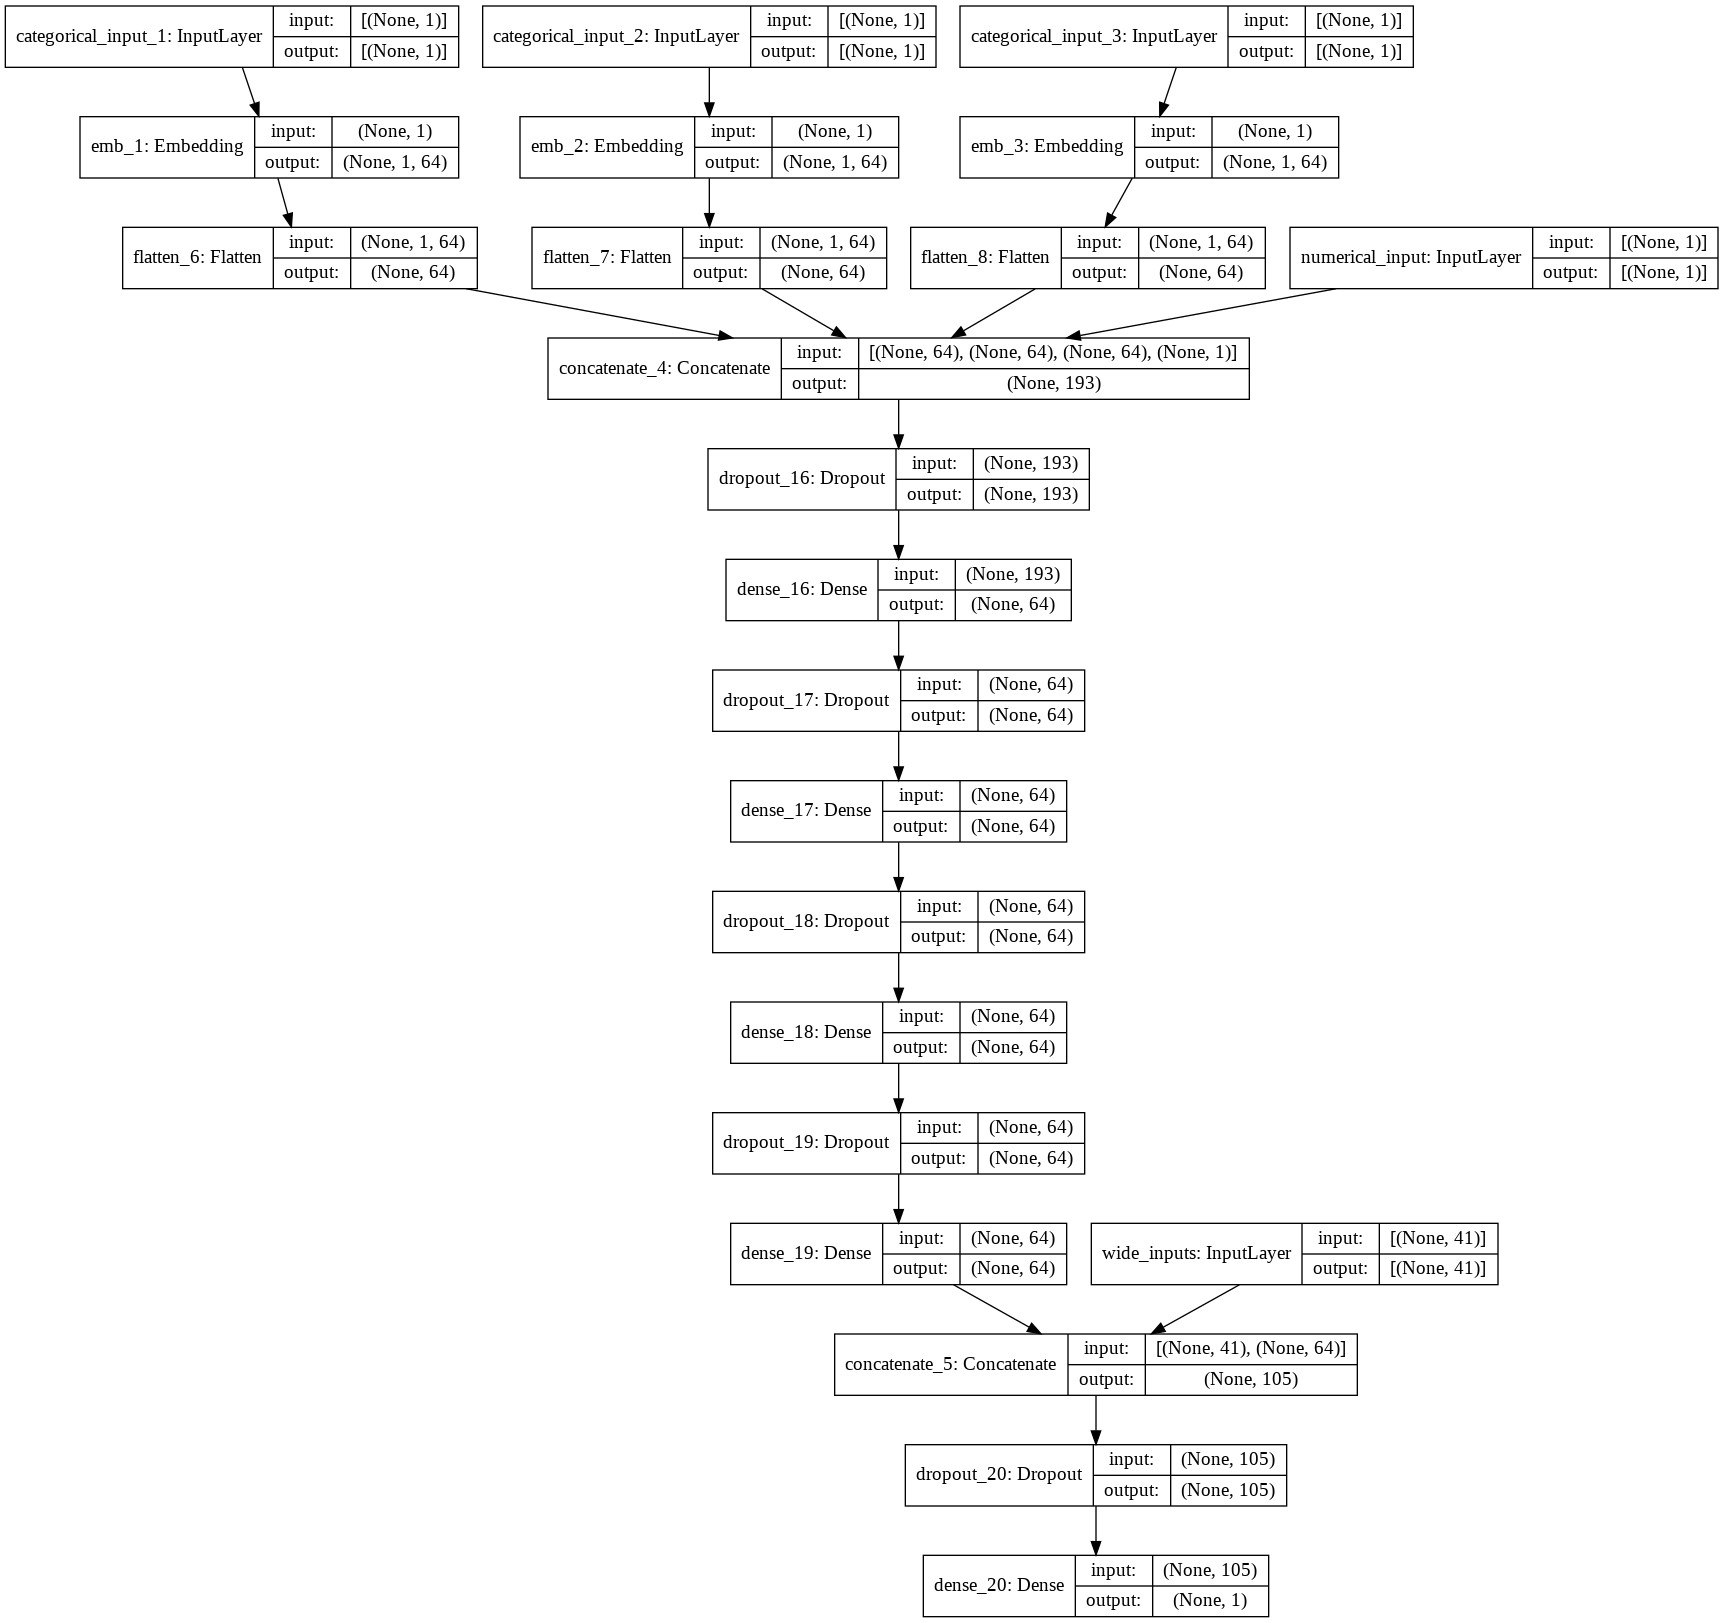

In [ ]:
#Combine wide and deep into one model

x = concatenate([wide_inputs, deep_output])
x = Dropout(rate=0.2)(x)

wide_and_deep_output = Dense(1, activation='softmax')(x)
wide_and_deep_model = Model(inputs=[wide_inputs]+[categorical_input_1] + 
                            [categorical_input_2] + [categorical_input_3] + 
                            [numerical_input], outputs=wide_and_deep_output)

wide_and_deep_model.summary()
plot_model(wide_and_deep_model, to_file='wide_and_deep_model.png',show_shapes=True, show_layer_names=True)

#Prepare data for Train and Test

In [ ]:
df['rating'].head()

0    4
1    5
2    4
3    4
4    5
Name: rating, dtype: int64

In [ ]:
#Split data
X = pd.concat([df_wide, df_deep],axis=1)
y = df[['rating']]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
def prepare_independent_variables(X):
  """Split X dataframe into its separate input components for the neural network """
  wide_inputs = X[['x0_F_administrator', 'x0_F_artist', 'x0_F_educator', 'x0_F_engineer',
                     'x0_F_entertainment', 'x0_F_executive', 'x0_F_healthcare',
                     'x0_F_homemaker', 'x0_F_lawyer', 'x0_F_librarian', 'x0_F_marketing',
                     'x0_F_none', 'x0_F_other', 'x0_F_programmer', 'x0_F_retired',
                     'x0_F_salesman', 'x0_F_scientist', 'x0_F_student', 'x0_F_technician',
                     'x0_F_writer', 'x0_M_administrator', 'x0_M_artist', 'x0_M_doctor',
                     'x0_M_educator', 'x0_M_engineer', 'x0_M_entertainment',
                     'x0_M_executive', 'x0_M_healthcare', 'x0_M_homemaker', 'x0_M_lawyer',
                     'x0_M_librarian', 'x0_M_marketing', 'x0_M_none', 'x0_M_other',
                     'x0_M_programmer', 'x0_M_retired', 'x0_M_salesman', 'x0_M_scientist',
                     'x0_M_student', 'x0_M_technician', 'x0_M_writer']].values
  categorical_input_1 = X[['gender']].values
  categorical_input_2 = X[['occupation']].values
  categorical_input_3 = X[['genre']].values
  numerical_input = X[['age']].values

  return wide_inputs, categorical_input_1, categorical_input_2, categorical_input_3, numerical_input

In [ ]:
wide_inputs_train, categorical_input_1_train, categorical_input_2_train, \
categorical_input_3_train, numerical_input_train = prepare_independent_variables(X_train)

wide_inputs_test, categorical_input_1_test, categorical_input_2_test, \
categorical_input_3_test, numerical_input_test = prepare_independent_variables(X_test)

y_train = y_train.values
y_test = y_test.values

#Compile, Train, Evaluate

In [ ]:
#!pip install tensorflow-addons
#import tensorflow_addons as tfa

optimizers = [tf.keras.optimizers.Adagrad(learning_rate=0.01),
              tf.keras.optimizers.Ftrl(learning_rate=0.01)]
optimizers_and_layers = [(optimizers[0], wide_and_deep_model.layers[19]),
                         (optimizers[1], wide_and_deep_model.layers[17])]
optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)
wide_and_deep_model.compile(loss='categorical_crossentropy',optimizer=optimizer, metrics=['accuracy'])

In [ ]:
#keras.backend.get_session().run(tf.global_variables_initializer())

In [ ]:
#date_time = (datetime.utcnow() + timedelta(hours=8)).strftime('[%Y-%m-%d %H-%M-%S]')
#tensorboard = TensorBoard(log_dir='./logs/tensorboard/{}'.format(date_time))

#early_stopping = EarlyStopping(monitor='val_loss', patience=5)
#model_checkpoint = ModelCheckpoint(filepath='./model/wide_and_deep_model.h5', 
              #                     monitor='val_loss',
               #                    save_weights_only=True, 
                #                   save_best_only=True)
#callbacks = [model_checkpoint,early_stopping, tensorboard]


In [ ]:
history = wide_and_deep_model.fit(x={'wide_inputs': wide_inputs_train,
                           'categorical_input_1': categorical_input_1_train,
                           'categorical_input_2': categorical_input_2_train,
                           'categorical_input_3': categorical_input_3_train,
                           'numerical_input': numerical_input_train},
                        y=y_train, batch_size=32, epochs=100, verbose=1, validation_split=0.2)

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

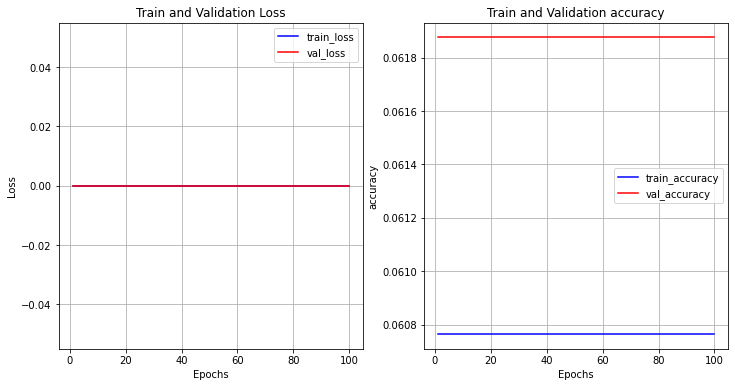

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) +1)
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(epochs, loss, color='blue',label='train_loss')
ax1.plot(epochs, val_loss, color='red',label='val_loss')
ax1.set_title("Train and Validation Loss")
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1,2,2)
ax2.plot(epochs, accuracy, color='blue',label='train_accuracy')
ax2.plot(epochs, val_accuracy, color='red',label='val_accuracy')
ax2.set_title("Train and Validation accuracy")
ax2.set_xlabel('Epochs')
ax2.set_ylabel('accuracy')
ax2.grid()
ax2.legend()

In [ ]:
wide_and_deep_model.evaluate(x={'wide_inputs': wide_inputs_test,
                                'categorical_input_1': categorical_input_1_test,
                                'categorical_input_2': categorical_input_2_test,
                               'categorical_input_3': categorical_input_3_test,
                                'numerical_input': numerical_input_test},
                             y=y_test,
                             batch_size=32, verbose=1)

625/625 [==============================] - 1s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0615


[0.0, 0.06154999881982803]

In [ ]:
predictions = wide_and_deep_model.predict(x={'wide_inputs': wide_inputs_test,
                                             'categorical_input_1': categorical_input_1_test,
                                             'categorical_input_2': categorical_input_2_test,
                                             'categorical_input_3': categorical_input_3_test,
                                             'numerical_input': numerical_input_test},
                                          batch_size=32, verbose=1)

625/625 [==============================] - 2s 1ms/step
